In [1]:
# Importing necessary libraries
import os
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchsummary import summary
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Checking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}\n")


Using device: cuda



In [2]:
# Defining the dataset path
dataset_path = "PBC_dataset_normal_DIB"

# Applying Transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((360, 360)),                                                  # Resizing to 360x360           
    transforms.RandomHorizontalFlip(p=0.5),                                         # Applying Horizontal flip with 50% probability
    transforms.RandomRotation(degrees=15),                                          # Applying Rotation range of 15 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Applying Color jitter parameters
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)),                          # Adding affine transformations 
    transforms.ToTensor(),                                                          # Converting images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])                 # Normalizing the range to [-1, 1]
])

In [3]:
# Loading of dataset
print("Loading dataset...\n")
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Printing the classes (folders) being loaded
print("Classes found in dataset:\n")
for cls, count in zip(dataset.classes, np.bincount([sample[1] for sample in dataset.samples])):
    print(f" - {cls}: {count} images")

# Getting dataset's indices and labels
indices = np.arange(len(dataset))
labels = [label for _, label in dataset.samples]

# Performing train - test split (75% train, 25% test)
train_indices, test_indices = train_test_split(indices, test_size=0.25, stratify=labels, random_state=42)

# Creating subsets for train and test
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Calculating class weights for the training set
train_labels = [dataset.samples[i][1] for i in train_indices]
train_class_counts = np.bincount(train_labels)
train_class_weights = 1.0 / train_class_counts
train_class_weights = torch.tensor(train_class_weights, dtype=torch.float)

# Applying Weighted sampler for training set
train_sample_weights = [train_class_weights[label] for label in train_labels]
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)  # Regular shuffling for testing

# Creating of DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)

# Printing the number of images per class in the train and test splits
train_class_counts_split = np.bincount([train_labels[i] for i in range(len(train_labels))])
test_labels = [dataset.samples[i][1] for i in test_indices]
test_class_counts_split = np.bincount([test_labels[i] for i in range(len(test_labels))])

print("\nNumber of images per class in the training set (75%):\n")
for cls, count in zip(dataset.classes, train_class_counts_split):
    print(f" - {cls}: {count} images")

print("\nNumber of images per class in the testing set (25%):\n")
for cls, count in zip(dataset.classes, test_class_counts_split):
    print(f" - {cls}: {count} images")

Loading dataset...

Classes found in dataset:

 - Basophil: 1218 images
 - Eosinophil: 3117 images
 - Erythroblast: 1551 images
 - Ig: 2895 images
 - Lymphocyte: 1214 images
 - Monocyte: 1420 images
 - Neutrophil: 3329 images
 - Platelet: 2348 images

Number of images per class in the training set (75%):

 - Basophil: 913 images
 - Eosinophil: 2338 images
 - Erythroblast: 1163 images
 - Ig: 2171 images
 - Lymphocyte: 911 images
 - Monocyte: 1065 images
 - Neutrophil: 2497 images
 - Platelet: 1761 images

Number of images per class in the testing set (25%):

 - Basophil: 305 images
 - Eosinophil: 779 images
 - Erythroblast: 388 images
 - Ig: 724 images
 - Lymphocyte: 303 images
 - Monocyte: 355 images
 - Neutrophil: 832 images
 - Platelet: 587 images


In [4]:
class ForwardConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ForwardConvBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x):
        return self.conv_block(x)

class BCNet(nn.Module):
    def __init__(self, num_classes=8):
        super(BCNet, self).__init__()
        
        # Initial Convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
        )
        
        # Forward Conv. Blocks
        self.for_block1 = ForwardConvBlock(32, 64)
        self.for_block2 = ForwardConvBlock(64, 128)
        self.for_block3 = ForwardConvBlock(128, 256)
        self.for_block4 = ForwardConvBlock(256, 512)

        # Max Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layers
        self.fc = nn.Sequential(nn.Linear(512, num_classes))

        # Softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.pool(self.for_block1(x))
        x = self.pool(self.for_block2(x))
        x = self.pool(self.for_block3(x))
        x = self.pool(self.for_block4(x))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)           # Flatten for the fully connected layer
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [5]:
# Defining the model
model = BCNet(num_classes=8)

# Moving the model to the device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Printing the model summary
print("\nModel Summary:")
summary(model, input_size=(3, 360, 360))

# Checking the size of the first batch of images
for inputs, labels in train_loader:
    print(inputs.shape)  
    break


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 360, 360]             896
       BatchNorm2d-2         [-1, 32, 360, 360]              64
         LeakyReLU-3         [-1, 32, 360, 360]               0
            Conv2d-4         [-1, 64, 360, 360]          18,496
       BatchNorm2d-5         [-1, 64, 360, 360]             128
         LeakyReLU-6         [-1, 64, 360, 360]               0
            Conv2d-7         [-1, 64, 360, 360]          36,928
       BatchNorm2d-8         [-1, 64, 360, 360]             128
         LeakyReLU-9         [-1, 64, 360, 360]               0
 ForwardConvBlock-10         [-1, 64, 360, 360]               0
        MaxPool2d-11         [-1, 64, 180, 180]               0
           Conv2d-12        [-1, 128, 180, 180]          73,856
      BatchNorm2d-13        [-1, 128, 180, 180]             256
        LeakyReLU-14   

In [6]:
# Setting up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 8
train_losses = []
train_accuracies = []

# Using mixed precision for faster training
scaler = torch.amp.GradScaler()

print("\nTraining Process is going on.........\n")

# Training Loop
for epoch in range(epochs):
    model.train()  # Setting the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Mixed precision
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scaling the loss, calling backward(), and updating the optimizer
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Tracking the loss
        running_loss += loss.item()

        # Calculating the accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Average loss and accuracy for this perticular epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("\nTraining is Completed!\n")

mean_loss = sum(train_losses) / len(train_losses)
mean_accuracy = sum(train_accuracies) / len(train_accuracies)

print("\n---------------------------------------------------------------------------\n")


Training Process is going on.........

Epoch [1/8], Loss: 1.9505, Accuracy: 30.93%
Epoch [2/8], Loss: 1.8462, Accuracy: 43.58%
Epoch [3/8], Loss: 1.7099, Accuracy: 58.11%
Epoch [4/8], Loss: 1.6326, Accuracy: 65.39%
Epoch [5/8], Loss: 1.5896, Accuracy: 69.28%
Epoch [6/8], Loss: 1.5549, Accuracy: 72.56%
Epoch [7/8], Loss: 1.5231, Accuracy: 75.60%
Epoch [8/8], Loss: 1.5027, Accuracy: 77.79%

Training is Completed!


---------------------------------------------------------------------------



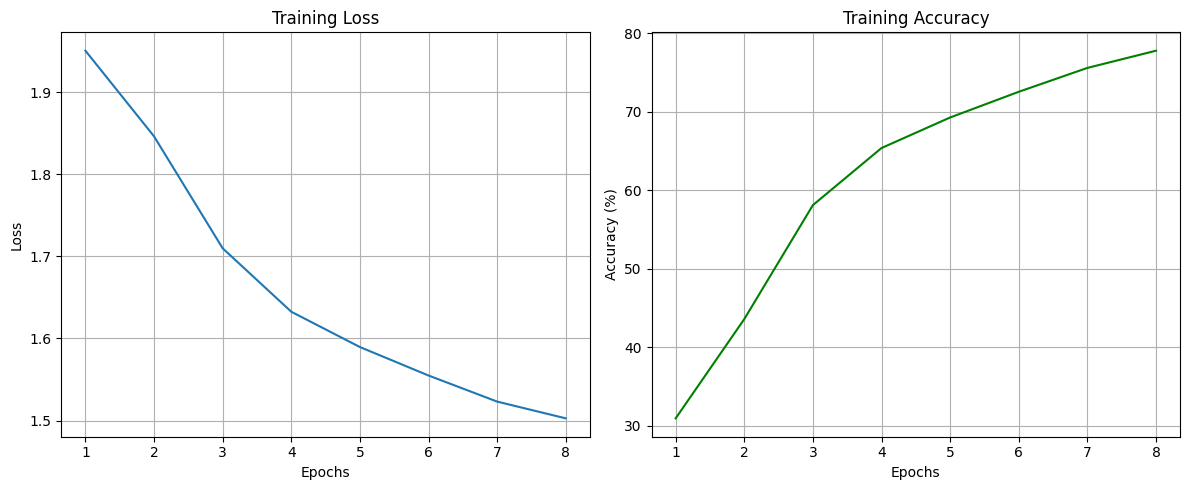

In [7]:
# Plotting the Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plotting Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plotting Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Saving the graph as an image file
plt.savefig('Training_Graph.png')
print("Training Graph saved to 'Training_Graph.png'\n")

# Saving the model weights
torch.save(model.state_dict(), "Trained_MBC_Data.pth")
print("Model saved to 'Trained_MBC_Data.pth'\n")

Training Graph saved to 'Training_Graph.png'

Model saved to 'Trained_MBC_Data.pth'



<Figure size 640x480 with 0 Axes>

In [9]:
# Setting the model to evaluation / testing mode
model.eval()

print("\n\nTesting Process is going on.........\n")

# Initializing variables to track loss and accuracy
test_loss = 0.0
correct_preds_test = 0
total_preds_test = 0
all_preds = []
all_labels = []

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Ig', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Using the same loss function and optimizer used during training
criterion = torch.nn.CrossEntropyLoss()

# Evaluating the model on the test dataset
with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)  # Forward pass
        
        # Computing the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)  # Accumulating the loss
        
        # Computing the accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds_test += (predicted == labels).sum().item()
        total_preds_test += labels.size(0)
        
        # Collecting predictions and labels for classification report
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculating the average test loss and accuracy
test_loss /= len(test_loader.dataset)  
test_accuracy = (correct_preds_test / total_preds_test ) * 100  

print("\nTesting is Completed!\n")



Testing Process is going on.........


Testing is Completed!



In [10]:
# Printing the detailed classification report 
print("Classification Report on Testing Set:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report on Testing Set:

              precision    recall  f1-score   support

    Basophil       0.37      0.94      0.53       305
  Eosinophil       0.91      0.83      0.86       779
Erythroblast       0.76      0.82      0.79       388
          Ig       0.74      0.15      0.25       724
  Lymphocyte       0.73      0.73      0.73       303
    Monocyte       0.75      0.70      0.73       355
  Neutrophil       0.76      0.93      0.84       832
    Platelet       0.98      0.95      0.97       587

    accuracy                           0.74      4273
   macro avg       0.75      0.76      0.71      4273
weighted avg       0.78      0.74      0.72      4273



In [11]:
# Printing the file names of the test set images for each class
test_class_names = dataset.classes
test_class_files = {cls: [] for cls in test_class_names}

# Retrieving samples of the test dataset
test_samples = [dataset.samples[idx] for idx in test_dataset.indices]

# Collecting file names for each class
for file_path, label in test_samples:     
    test_class_name = class_names[label]
    test_class_files[test_class_name].append(file_path)

# Printing file names for each class (showing 10 files per class)
for test_class_name, files in test_class_files.items():
    print(f"\nClass: {test_class_name}\n")
    for file in files[:10]: 
        print(f"  {file}")

# Function to load an image from a file path and predict its class
def classify_image(image_path):
    # Loading the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    # Displaying the input image
    img_disp = image.squeeze(0).cpu()
    img_disp = img_disp.permute(1, 2, 0)                                        # CHW → HWC
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())  # scale to [0, 1]
    plt.imshow(img_disp)
    plt.title(f"Input Image")
    plt.axis('off')
    plt.show()

    # Model inference (i.e., Classification)
    output = model(image)
    _, predicted = torch.max(output, 1)  # Getting the predicted class

    # Getting the class label
    predicted_label = predicted.item()

    # The true label can be obtained directly from the folder structure
    true_class_label = class_names.index(image_path.split('/')[-2]) 

    # Checking if classification is correct or wrong
    if predicted_label == true_class_label:
        classification_status = "Yay!!! Correct Classification. I now think I can classify the Blood Cells."
    else:
        classification_status = "Oops!!! Wrong Classification. I think I should train hard to classify the Blood Cells."

    # Printing the results
    print(f"\nTrue Class of the Blood Cell: {class_names[true_class_label]}")
    print(f"Predicted Class of the Blood Cell: {class_names[predicted_label]}")
    print(f"\n{classification_status}")


Class: Basophil

  PBC_dataset_normal_DIB/Basophil/BA_46660.jpg
  PBC_dataset_normal_DIB/Basophil/BA_589260.jpg
  PBC_dataset_normal_DIB/Basophil/BA_365212.jpg
  PBC_dataset_normal_DIB/Basophil/BA_600449.jpg
  PBC_dataset_normal_DIB/Basophil/BA_981874.jpg
  PBC_dataset_normal_DIB/Basophil/BA_912566.jpg
  PBC_dataset_normal_DIB/Basophil/BA_572677.jpg
  PBC_dataset_normal_DIB/Basophil/BA_80990.jpg
  PBC_dataset_normal_DIB/Basophil/BA_66312.jpg
  PBC_dataset_normal_DIB/Basophil/BA_121897.jpg

Class: Eosinophil

  PBC_dataset_normal_DIB/Eosinophil/EO_464699.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_198556.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_189413.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_398624.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_316082.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_817196.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_53483.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_336692.jpg
  PBC_dataset_normal_DIB/Eosinophil/EO_661088.jpg
  PBC_dataset_normal_DIB/Eosinophil/


Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Basophil/BA_46660.jpg


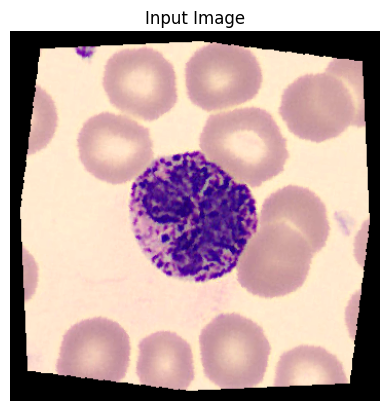


True Class of the Blood Cell: Basophil
Predicted Class of the Blood Cell: Basophil

Yay!!! Correct Classification. I now think I can classify the Blood Cells.



Do you want to classify another image? (yes/no):  yes

Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Eosinophil/EO_464699.jpg


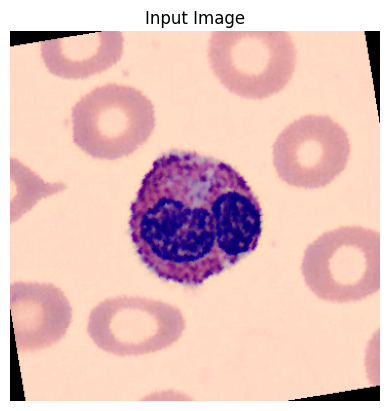


True Class of the Blood Cell: Eosinophil
Predicted Class of the Blood Cell: Eosinophil

Yay!!! Correct Classification. I now think I can classify the Blood Cells.



Do you want to classify another image? (yes/no):  yes

Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Erythroblast/ERB_267711.jpg


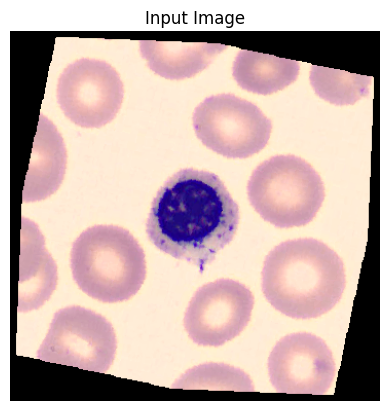


True Class of the Blood Cell: Erythroblast
Predicted Class of the Blood Cell: Erythroblast

Yay!!! Correct Classification. I now think I can classify the Blood Cells.



Do you want to classify another image? (yes/no):  yes

Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Ig/PMY_241.jpg


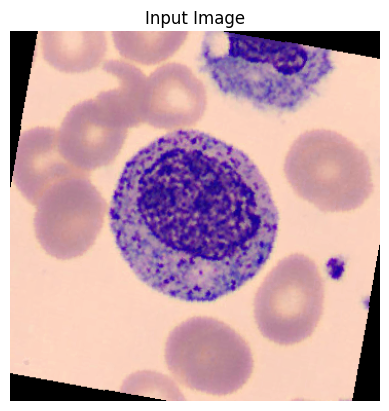


True Class of the Blood Cell: Ig
Predicted Class of the Blood Cell: Basophil

Oops!!! Wrong Classification. I think I should train hard to classify the Blood Cells.



Do you want to classify another image? (yes/no):  yes

Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Lymphocyte/LY_424808.jpg


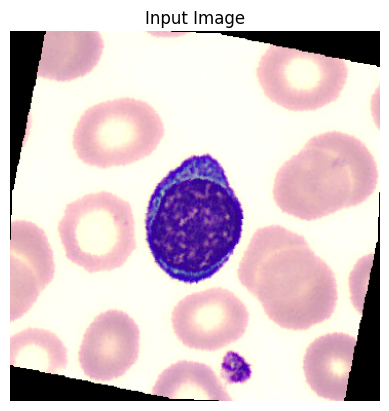


True Class of the Blood Cell: Lymphocyte
Predicted Class of the Blood Cell: Basophil

Oops!!! Wrong Classification. I think I should train hard to classify the Blood Cells.



Do you want to classify another image? (yes/no):  yes

Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Monocyte/MO_854196.jpg


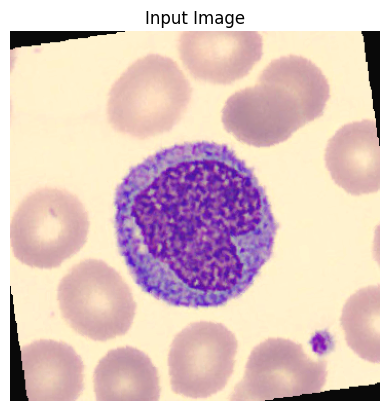


True Class of the Blood Cell: Monocyte
Predicted Class of the Blood Cell: Monocyte

Yay!!! Correct Classification. I now think I can classify the Blood Cells.



Do you want to classify another image? (yes/no):  yes

Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Neutrophil/SNE_825561.jpg


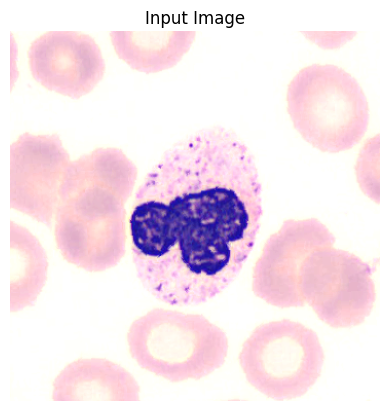


True Class of the Blood Cell: Neutrophil
Predicted Class of the Blood Cell: Neutrophil

Yay!!! Correct Classification. I now think I can classify the Blood Cells.



Do you want to classify another image? (yes/no):  yes

Enter the path to the Test Image from the file names given above: PBC_dataset_normal_DIB/Platelet/PLATELET_662037.jpg


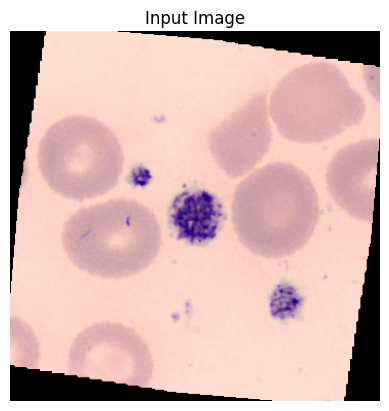


True Class of the Blood Cell: Platelet
Predicted Class of the Blood Cell: Platelet

Yay!!! Correct Classification. I now think I can classify the Blood Cells.



Do you want to classify another image? (yes/no):  no



Exiting the Program. Thank you!



In [12]:
# Main loop to continuously ask the user to input an image
while True:
    # Prompting the user to input the path to an image and validate the path
    while True:
        image_path = input("\nEnter the path to the Test Image from the file names given above:").strip()
        
        # Checking if the path ends with .jpg
        if image_path.lower().endswith('.jpg'):
            # Checking if the file exists
            if os.path.isfile(image_path):
                break
            else:
                print("\nThe file does not exist. Please Try again.")
        else:
            print("\nThe file must be a .jpg file. Please Try again.")

    # Calling the function to classify the image
    classify_image(image_path)

    # Asking the user if they want to classify another image or not
    while True:
        repeat = input("\nDo you want to classify another image? (yes/no): ").strip().lower()
        if repeat == 'yes':
            break
        elif repeat == 'no':
            print("\nExiting the Program. Thank you!\n")
            loop_exit = True
            break
        else:
            print("\nInvalid input. Please type 'yes' or 'no'")

    if 'loop_exit' in locals() and loop_exit:
        break

In [13]:
!jupyter nbconvert --to html MBC_Project.ipynb

[NbConvertApp] Converting notebook MBC_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 1878724 bytes to MBC_Project.html


In [14]:
# END